# total kinetic energy, total ocean heat content and average salinity
## Preprocessing
Load data, get cartesian coordinates, calculate time dependent volumes of cells and interpolate velocities onto rho grid.

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from features.roms_ds import make_cartesian_grid_3D, make_uv_lonlat, make_4D_depth
%aimport features.roms_ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
file_path = os.path.join(os.environ.get('projdir'),'data','analysis','raw','waom10_full_forcing','ocean_avg_000[1,2].nc')
print('Load file: ',file_path)
ds = xr.open_mfdataset(file_path,data_vars="minimal")
print('calculate dx,dy,dz and dV')
ds = make_cartesian_grid_3D(ds)
print('interpolate velocities on rho points')
ds = make_uv_lonlat(ds)

Load file:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/waom10_full_forcing/ocean_avg_000[1,2].nc
calculate dx,dy,dz and dV
interpolate velocities on rho points


Calculate 4D arrays of ocean heat content and kinetic energy.
**** CAUTION you need to write out density anomaly rho and use rho=rho0 instead of rho! ****

In [26]:
rho0 = 1027.0    # Reference density (kg/m^3)
Cp = 3974        # Specific heat of polar seawater (J/K/kg)
C2K = 273.15     # Celsius to Kelvin conversion

#rho = ds.rho+ds.rho0
rho=rho0
print('calculating ocean heat content of each cell at all times')
ohc = (ds.temp+C2K)*rho*Cp*ds.dV

ds['ohc'] = xr.DataArray(ohc,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
ds['ohc'] = ds.ohc.where(ds.mask_rho == 1)
ds.ohc.attrs = {"long_name":'Heat content',"units": 'J'}

print('calculating kinetic energy of each cell at all times')
ke = 0.5*rho*(ds.u_lonlat**2 + ds.v_lonlat**2)*ds.dV

ds['kine'] = xr.DataArray(ke,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
ds['kine'] = ds.kine.where(ds.mask_rho == 1)
ds.kine.attrs = {"long_name":'kinetic energy',"units": 'J'}

calculating ocean heat content of each cell at all times
calculating kinetic energy of each cell at all times


## Whole domain evolution
We start calculating and plotting the integrated/mean values of the wohle domain.

In [27]:
tohc = ds.ohc.sum(dim=['s_rho','xi_rho','eta_rho'])
tke = ds.kine.sum(dim=['s_rho','xi_rho','eta_rho'])
weights = ds.dV*rho/(ds.dV*rho).sum(dim=['s_rho','xi_rho','eta_rho'])
avg_salt = (ds.salt * weights).sum(dim=['s_rho','xi_rho','eta_rho'])

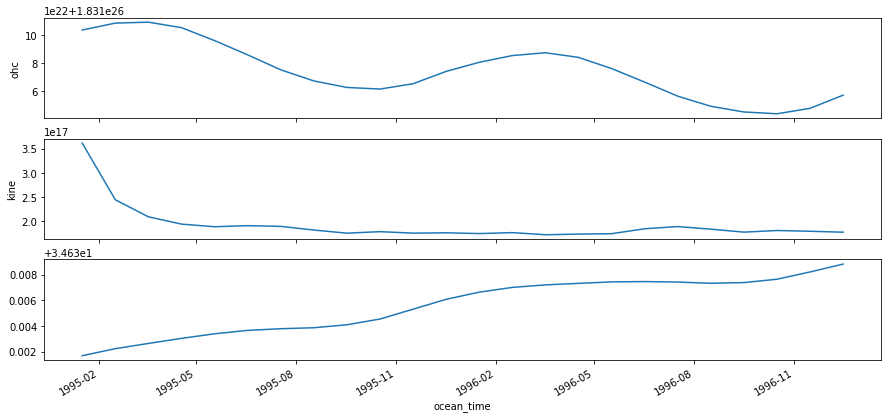

In [28]:
plt.close()
fig,(ax1,ax2,ax3)=plt.subplots(3,figsize=(15,7))
tohc.plot(ax=ax1)
tke.plot(ax=ax2)
avg_salt.plot(ax=ax3)
plt.show()

##  On shelf ocean
By selecting data above 1000m, south of 60S and under the cavity, I separate the for us interesting on shelf and slower spin up off shelf ocean. 

In [29]:
ds = make_4D_depth(ds)

<function matplotlib.pyplot.show>

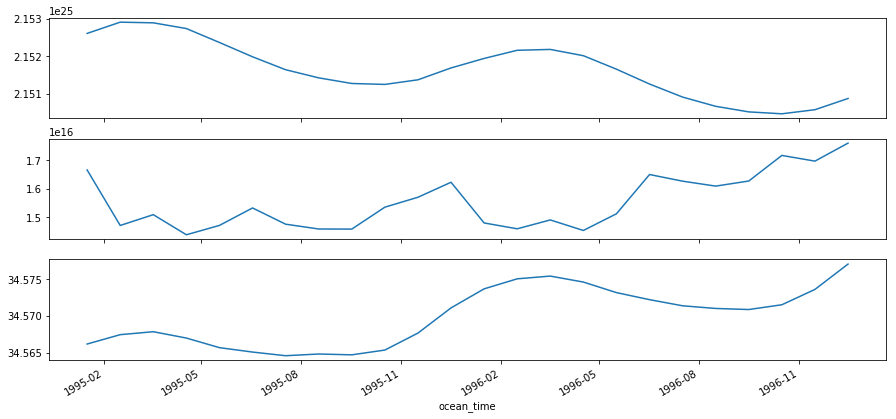

In [30]:
plt.close()
fig,(ax1,ax2,ax3)=plt.subplots(3,figsize=(15,7))
ds.ohc.where((ds.lat_rho<=-60) & ((ds.zice<0.0) | (ds.depth>-1000))).sum(dim=['s_rho','xi_rho','eta_rho']).plot(ax=ax1)
ds.kine.where((ds.lat_rho<=-60) & ((ds.zice<0.0) | (ds.depth>-1000))).sum(dim=['s_rho','xi_rho','eta_rho']).plot(ax=ax2)
weights = ds.dV.where((ds.lat_rho<=-60) & ((ds.zice<0.0) | (ds.depth>-1000)))*rho/(ds.dV.where((ds.lat_rho<=-60) & ((ds.zice<0.0) | (ds.depth>-1000)))*rho).sum(dim=['s_rho','xi_rho','eta_rho'])
(ds.salt * weights).where((ds.lat_rho<=-60) & ((ds.zice<0.0) | (ds.depth>-1000))).sum(dim=['s_rho','xi_rho','eta_rho']).plot(ax=ax3)
plt.show

show differnce to initiation